In [1]:
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt

In [2]:
conversationPath = './Chat.txt' 

In [3]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})'           # Mobile Number (Europe)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateTime(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), (([0-9][0-9])|[0-9]):([0-9][0-9]) ([a][m]|[p][m]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def getDataPoint(line):
    splitLine = line.split(' - ') 
    dateTime = splitLine[0] 
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:]) 
    if startsWithAuthor(message): 
        splitMessage = message.split(': ')
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

parsedData = [] 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)    
    messageBuffer = [] # Buffer to capture intermediate output for multi-line messages
    date, time, author = None, None, None 
    
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateTime(line): #this indicates the beginning of a new message
            if len(messageBuffer) > 0: # Check if the message buffer contains characters from previous iterations
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) # Append message to buffer
        else:
            messageBuffer.append(line) # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer

            
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
df.head()

,Date,Time,Author,Message
0,17/07/19,12:42 am,None,"Nachiket Agni created group ""Dhwani Informal K..."
1,17/07/19,12:42 am,None,Nachiket Agni added you
2,17/07/19,12:42 am,None,"Nachiket Agni added +91 73084 92757, +91 77620..."
3,17/07/19,12:54 am,None,"Toshi Priya changed the subject from ""Dhwani I..."
4,17/07/19,1:00 am,None,"Ayush Khedia changed the subject from ""Dhwani ..."


In [4]:
df.tail()

,Date,Time,Author,Message
10596,02/04/20,8:02 pm,George Johnny,Ek aur hai ladki growl karne wale log
10597,02/04/20,8:03 pm,George Johnny,Baby metal
10598,02/04/20,8:03 pm,George Johnny,Koi suna hai?
10599,02/04/20,8:05 pm,Harsh Anand,🙋‍♂️Karate
10600,02/04/20,8:18 pm,George Johnny,😂


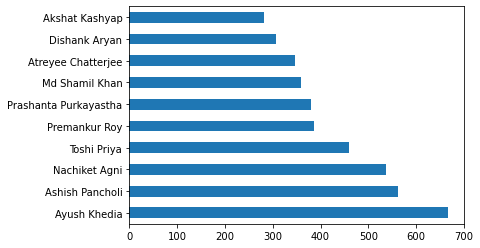

In [5]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
top_10_author_value_counts = author_value_counts.head(10) # Number of messages per author for the top 10 most active authors
top_10_author_value_counts.plot.barh() 

In [6]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
0,17/07/19,12:42 am,None,"Nachiket Agni created group ""Dhwani Informal K..."
1,17/07/19,12:42 am,None,Nachiket Agni added you
2,17/07/19,12:42 am,None,"Nachiket Agni added +91 73084 92757, +91 77620..."
3,17/07/19,12:54 am,None,"Toshi Priya changed the subject from ""Dhwani I..."
4,17/07/19,1:00 am,None,"Ayush Khedia changed the subject from ""Dhwani ..."


         Date      Time                 Author          Message
12   21/07/19  12:18 am  Prashanta Purkayastha  <Media omitted>
19   21/07/19   2:05 am           Ayush Khedia  <Media omitted>
216  29/07/19  12:02 pm            Sushil Oram  <Media omitted>
282  30/07/19   6:10 pm         Akshat Kashyap  <Media omitted>
289  31/07/19  10:57 pm          Premankur Roy  <Media omitted>


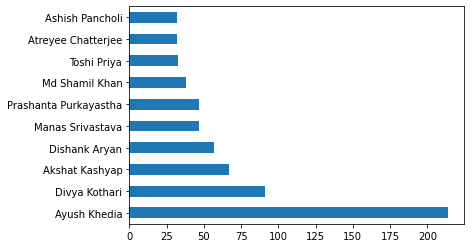

In [7]:
media_messages_df = df[df['Message'] == '<Media omitted>']
print(media_messages_df.head())

author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts.plot.barh()

In [8]:
messages_df = df.drop(null_authors_df.index) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()

,Date,Time,Author,Message
9,17/07/19,7:55 am,Sudakshina Bhattacharjee,Oh damn. 🌚
10,17/07/19,8:51 am,Ruchira Mishra,🌚
11,19/07/19,1:27 pm,Toshi Priya,I am adding our Faculty Advisors to Dhwani K16...
13,21/07/19,12:18 am,Akshat Kashyap,Pata hai
14,21/07/19,12:18 am,Toshi Priya,Han theek se rakho wahi


In [12]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [13]:
messages_df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count
9,17/07/19,7:55 am,Sudakshina Bhattacharjee,Oh damn. 🌚,10,3
10,17/07/19,8:51 am,Ruchira Mishra,🌚,1,1
11,19/07/19,1:27 pm,Toshi Priya,I am adding our Faculty Advisors to Dhwani K16...,116,20
13,21/07/19,12:18 am,Akshat Kashyap,Pata hai,8,2
14,21/07/19,12:18 am,Toshi Priya,Han theek se rakho wahi,23,5


Text(0, 0.5, 'Authors')

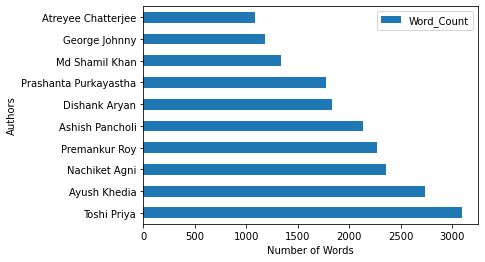

In [16]:
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

In [15]:
messages_df['Letter_Count'].sum(), messages_df['Word_Count'].sum()

(251305, 44046)

Text(0, 0.5, 'Frequency')

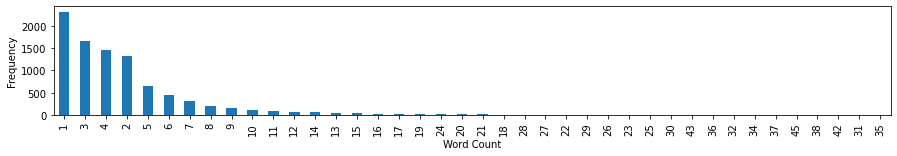

In [17]:

plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Authors')

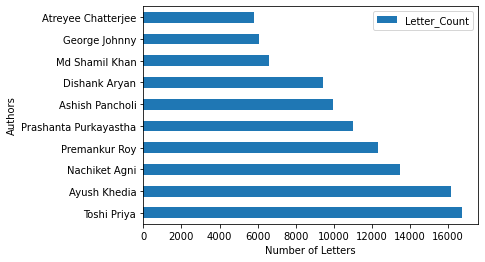

In [18]:
total_letter_count_grouped_by_author = messages_df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_grouped_by_author = total_letter_count_grouped_by_author.sort_values('Letter_Count', ascending=False)
top_10_sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_grouped_by_author.head(10)
top_10_sorted_total_letter_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Letters')
plt.ylabel('Authors')

Text(0, 0.5, 'Frequency')

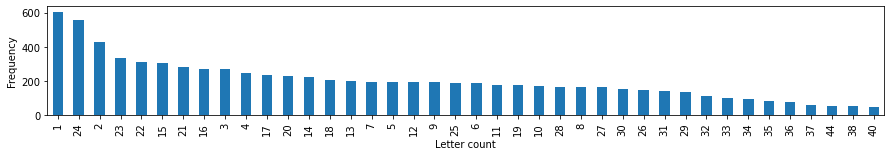

In [19]:
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Date')

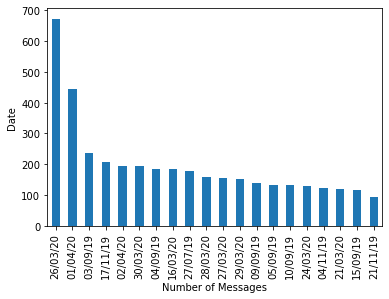

In [23]:
messages_df['Date'].value_counts().head(20).plot.bar() # Top 10 Dates on which the most number of messages were sent
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Text(0, 0.5, 'Time')

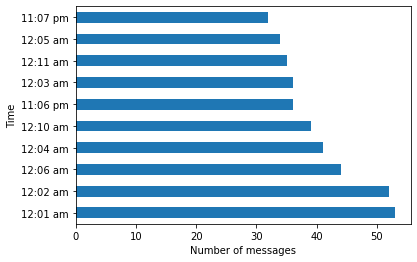

In [25]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

In [26]:
def HourSplitTo24(x):
    ap=x.split(" ")
    hour=int(ap[0].split(":")[0]) 
    alpha=ap[1]
    if alpha=="am" and hour==12:
        return "24"
    if alpha=="pm" and hour==12:
        return "12"
    if alpha=="am":
        return(str(hour))
    if alpha=="pm":
        return (str(hour+12))
    
    
messages_df['Hour'] = messages_df['Time'].apply(lambda x : HourSplitTo24(x))

In [27]:
messages_df.head()

,Date,Time,Author,Message,Letter_Count,Word_Count,Hour
9,17/07/19,7:55 am,Sudakshina Bhattacharjee,Oh damn. 🌚,10,3,7
10,17/07/19,8:51 am,Ruchira Mishra,🌚,1,1,8
11,19/07/19,1:27 pm,Toshi Priya,I am adding our Faculty Advisors to Dhwani K16...,116,20,13
13,21/07/19,12:18 am,Akshat Kashyap,Pata hai,8,2,24
14,21/07/19,12:18 am,Toshi Priya,Han theek se rakho wahi,23,5,24


Text(0, 0.5, 'Hour of Day')

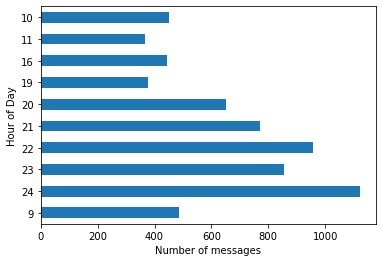

In [28]:

messages_df['Hour'].value_counts().head(10).sort_index(ascending=False).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')